In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
%matplotlib inline

Load Data

In [131]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Find, Plot Columns in Training Set with NAN Values

{'LotFrontage': 259,
 'Alley': 1369,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinType2': 38,
 'Electrical': 1,
 'FireplaceQu': 690,
 'GarageType': 81,
 'GarageYrBlt': 81,
 'GarageFinish': 81,
 'GarageQual': 81,
 'GarageCond': 81,
 'PoolQC': 1453,
 'Fence': 1179,
 'MiscFeature': 1406}

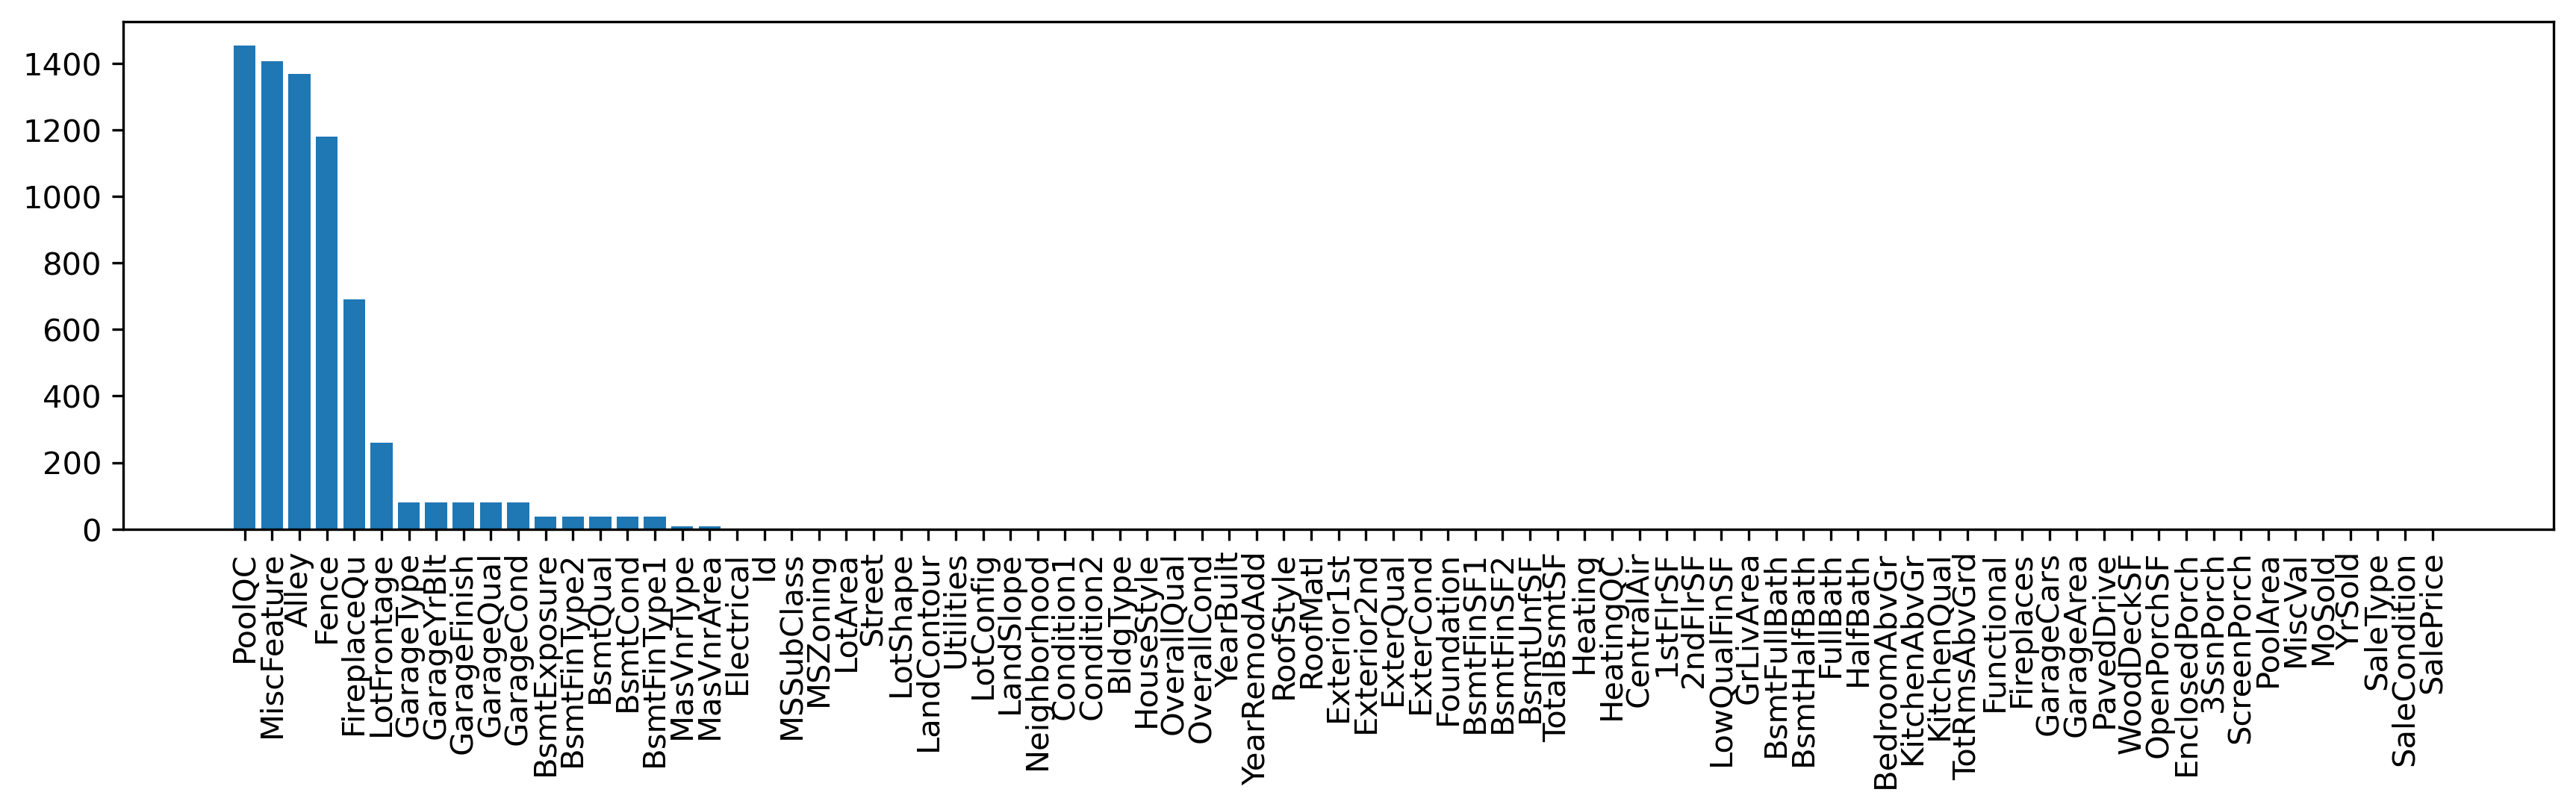

In [132]:
nanCount = {col:train[col].isna().sum() for col in train.columns}
nanCountSorted = np.asarray(sorted(nanCount.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(14,3), dpi=300)
plt.bar(nanCountSorted[:,0], nanCountSorted[:,1].astype(np.int))
plt.xticks(range(len(nanCountSorted[:,0])), nanCountSorted[:,0], rotation='vertical')

a = {key:value for key,value in nanCount.items() if value > 0}
a


Find Columns in Test Set with NAN Values

In [133]:
nanCount = {col:test[col].isna().sum() for col in test.columns}
nanCountSorted = np.asarray(sorted(nanCount.items(), key=lambda item: item[1], reverse=True))
b = {key:value for key,value in nanCount.items() if value > 0}
b

{'MSZoning': 4,
 'LotFrontage': 227,
 'Alley': 1352,
 'Utilities': 2,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'MasVnrType': 16,
 'MasVnrArea': 15,
 'BsmtQual': 44,
 'BsmtCond': 45,
 'BsmtExposure': 44,
 'BsmtFinType1': 42,
 'BsmtFinSF1': 1,
 'BsmtFinType2': 42,
 'BsmtFinSF2': 1,
 'BsmtUnfSF': 1,
 'TotalBsmtSF': 1,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'KitchenQual': 1,
 'Functional': 2,
 'FireplaceQu': 730,
 'GarageType': 76,
 'GarageYrBlt': 78,
 'GarageFinish': 78,
 'GarageCars': 1,
 'GarageArea': 1,
 'GarageQual': 78,
 'GarageCond': 78,
 'PoolQC': 1456,
 'Fence': 1169,
 'MiscFeature': 1408,
 'SaleType': 1}

Find the set of columns which contain null values in the test set, but not the training set. Fill these values separately from rest.

In [134]:
bdif = {key:b[key] for key in list(set(b.keys()).difference(set(a.keys())))}

for col in list(bdif.keys()):
    test[col].fillna(test[col].mode()[0], inplace=True)

{'KitchenQual': 1,
 'Functional': 2,
 'MSZoning': 4,
 'GarageArea': 1,
 'TotalBsmtSF': 1,
 'SaleType': 1,
 'Utilities': 2,
 'BsmtHalfBath': 2,
 'BsmtUnfSF': 1,
 'BsmtFinSF1': 1,
 'GarageCars': 1,
 'Exterior2nd': 1,
 'BsmtFullBath': 2,
 'Exterior1st': 1,
 'BsmtFinSF2': 1}

Fill rest of nan values. Fill LotFrontage with 0 since nan corresponds to no lot. Remaining nan values only represent < 90 values per column (lot frontage had ~250), so I just filled the rest with the mode.

In [ ]:
train['LotFrontage'].fillna(0, inplace=True)
test['LotFrontage'].fillna(0, inplace=True)

train['Electrical'].fillna(train['Electrical'].mode()[0], inplace=True)

for col in test.columns:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)

Get dummy variables for train and test set. Due to categories/categorical values that exist in one set, but not the other, I just took the intersection of the columns in both sets. Although this may result in data loss, I assumed that any additional categories in the test set, but not in the training set, must comprise a small portion of the data. Same goes for categories in train set but not test, as both datasets consist of over 1400 samples.

In [136]:
train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test)

shared_categories = set(train_dummies).intersection(set(test_dummies))

shared_cols= list(shared_categories)
test_dummies = test_dummies[shared_cols]
shared_cols.append('SalePrice')
train_dummies = train_dummies[shared_cols]

train_dummies = train_dummies.drop(['Id'], axis=1)
test_dummies = test_dummies.drop(['Id'], axis=1)

Use OLS regression to find significant variables

In [160]:
x = sm.add_constant(train_dummies.drop(['SalePrice'], axis=1))
model = sm.OLS(train_dummies.SalePrice, x)
results = model.fit()

C:\Users\19083\anaconda3\envs\compsci371d\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const                   102888.863855
SaleCondition_Family     18177.121150
Neighborhood_NWAmes     -12679.822343
SaleType_WD              -2662.151798
HalfBath                  1491.687960
                            ...      
Fence_MnWw               22753.648321
LotConfig_Corner         23755.312785
Exterior2nd_Stone        -3516.235507
Exterior2nd_MetalSd      17408.522809
BsmtExposure_Av          24117.160379
Length: 271, dtype: float64

<AxesSubplot:>

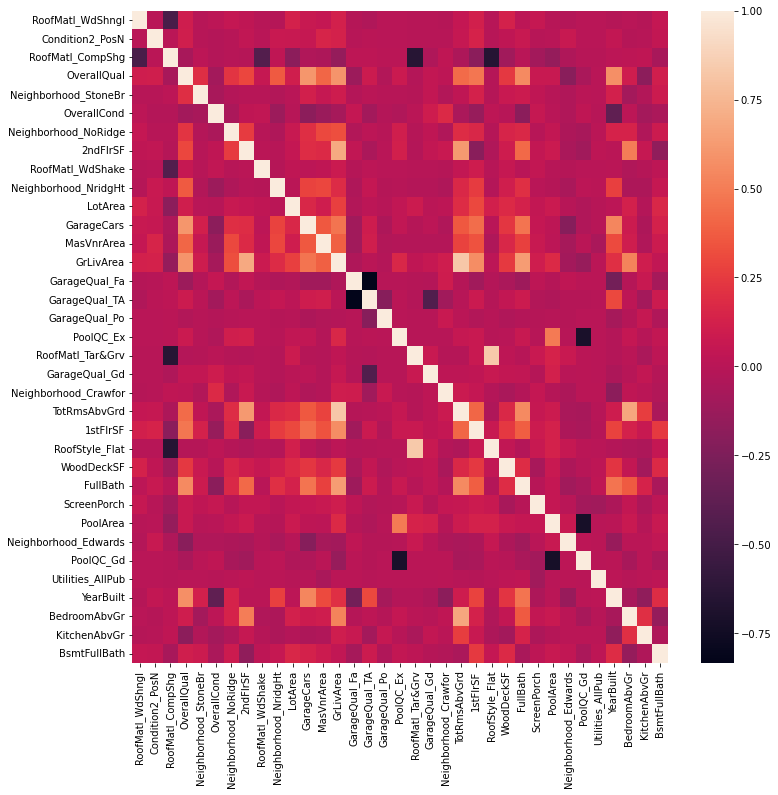

In [194]:
sig_vars = results.pvalues.where(results.pvalues < 0.05).dropna().sort_values().index

plt.figure(figsize=(12,12))
sns.heatmap(train_dummies[sig_vars].corr())

In [207]:
len(sig_vars) / 3

11.666666666666666

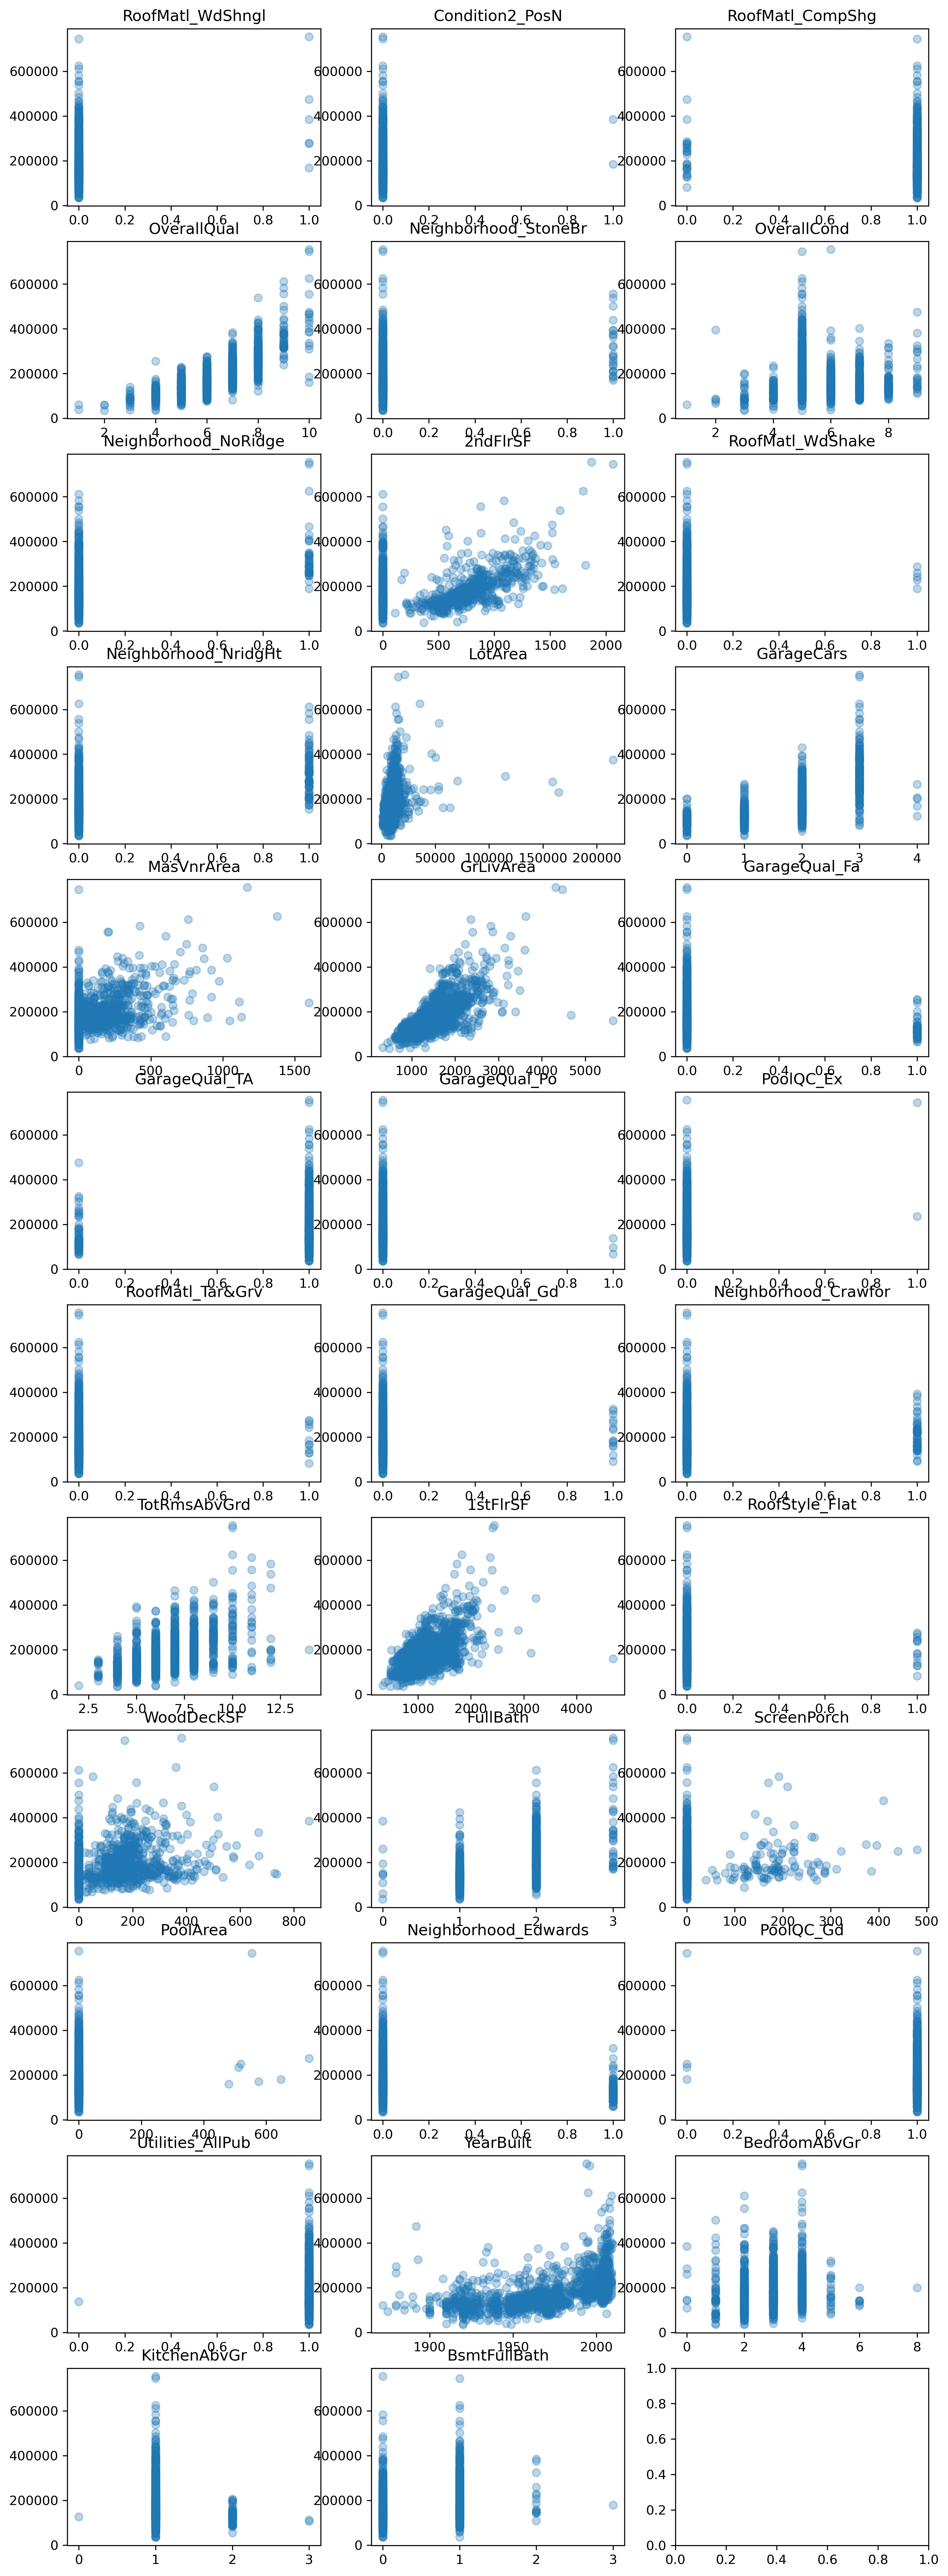

In [227]:
fig, axs = plt.subplots(int(np.ceil(len(sig_vars) / 3)), 3, figsize=(12,36), dpi=300)
for i in range(len(sig_vars)):
    axs[int(i / 3), i % 3].scatter(train_dummies[sig_vars[i]], train_dummies.SalePrice, alpha=0.3)
    axs[int(i / 3), i % 3].title.set_text(sig_vars[i])

In [153]:
# train_dummies.corr()['SalePrice'].sort_values(ascending=False)[:30]

SalePrice                1.000000
OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
FullBath                 0.560664
BsmtQual_Ex              0.553105
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
YearRemodAdd             0.507101
KitchenQual_Ex           0.504094
Foundation_PConc         0.497734
MasVnrArea               0.472614
Fireplaces               0.466929
ExterQual_Gd             0.452466
ExterQual_Ex             0.451164
BsmtFinType1_GLQ         0.434597
HeatingQC_Ex             0.434543
GarageFinish_Fin         0.419678
Neighborhood_NridgHt     0.402149
GarageYrBlt              0.397778
BsmtFinSF1               0.386420
SaleType_New             0.357509
SaleCondition_Partial    0.352060
MasVnrType_Stone         0.330476
Neighborhood_NoRidge     0.330424
WoodDeckSF               0.324413
KitchenQual_Gd

Implement random forest regressor

In [195]:
rf = RandomForestRegressor()
rf.fit(train_dummies[sig_vars], train_dummies['SalePrice'])

RandomForestRegressor()

In [139]:
# for i in range(len(train_dummies)):
#     print(str(train_dummies.iloc[i].SalePrice) + " " + str(rf.predict([train_dummies.loc[i, train_dummies.columns != 'SalePrice']])))

In [196]:
scores = []
for i in range(len(test_dummies)):
    scores.append(rf.predict([test_dummies[sig_vars].iloc[i]])[0])

In [197]:
result_data = {'Id':test.Id.values, 'SalePrice':np.asarray(scores)}
results = pd.DataFrame(result_data)
results.to_csv('sig_vars_results.csv', index=False)

In [90]:
sumNan = []
for i in test_dummies.columns:
    if test_dummies[i].isna().any():
        sumNan.append(i)

sumNan

[]

Implement XGBoost

In [148]:
xgboost_data = xgb.DMatrix(train_dummies.drop(['SalePrice'], axis=1), label=train_dummies.SalePrice)
params = {'max_depth':6}
boosted_tree = xgb.train(params, xgboost_data)

In [149]:
xgboost_test = xgb.DMatrix(test_dummies)
test_predictions = boosted_tree.predict(xgboost_test)

In [204]:
xgboost_data = xgb.DMatrix(train_dummies[sig_vars], label=train_dummies.SalePrice)
params = {'max_depth':8}
boosted_tree = xgb.train(params, xgboost_data)

In [205]:
xgboost_test = xgb.DMatrix(test_dummies[sig_vars])
test_predictions = boosted_tree.predict(xgboost_test)

In [206]:
# test_predictions
xgb_results_data = {'Id':test.Id.values, 'SalePrice':np.asarray(test_predictions)}
xgb_results = pd.DataFrame(xgb_results_data)
xgb_results.to_csv('xgb_sig_vars_results.csv', index=False)